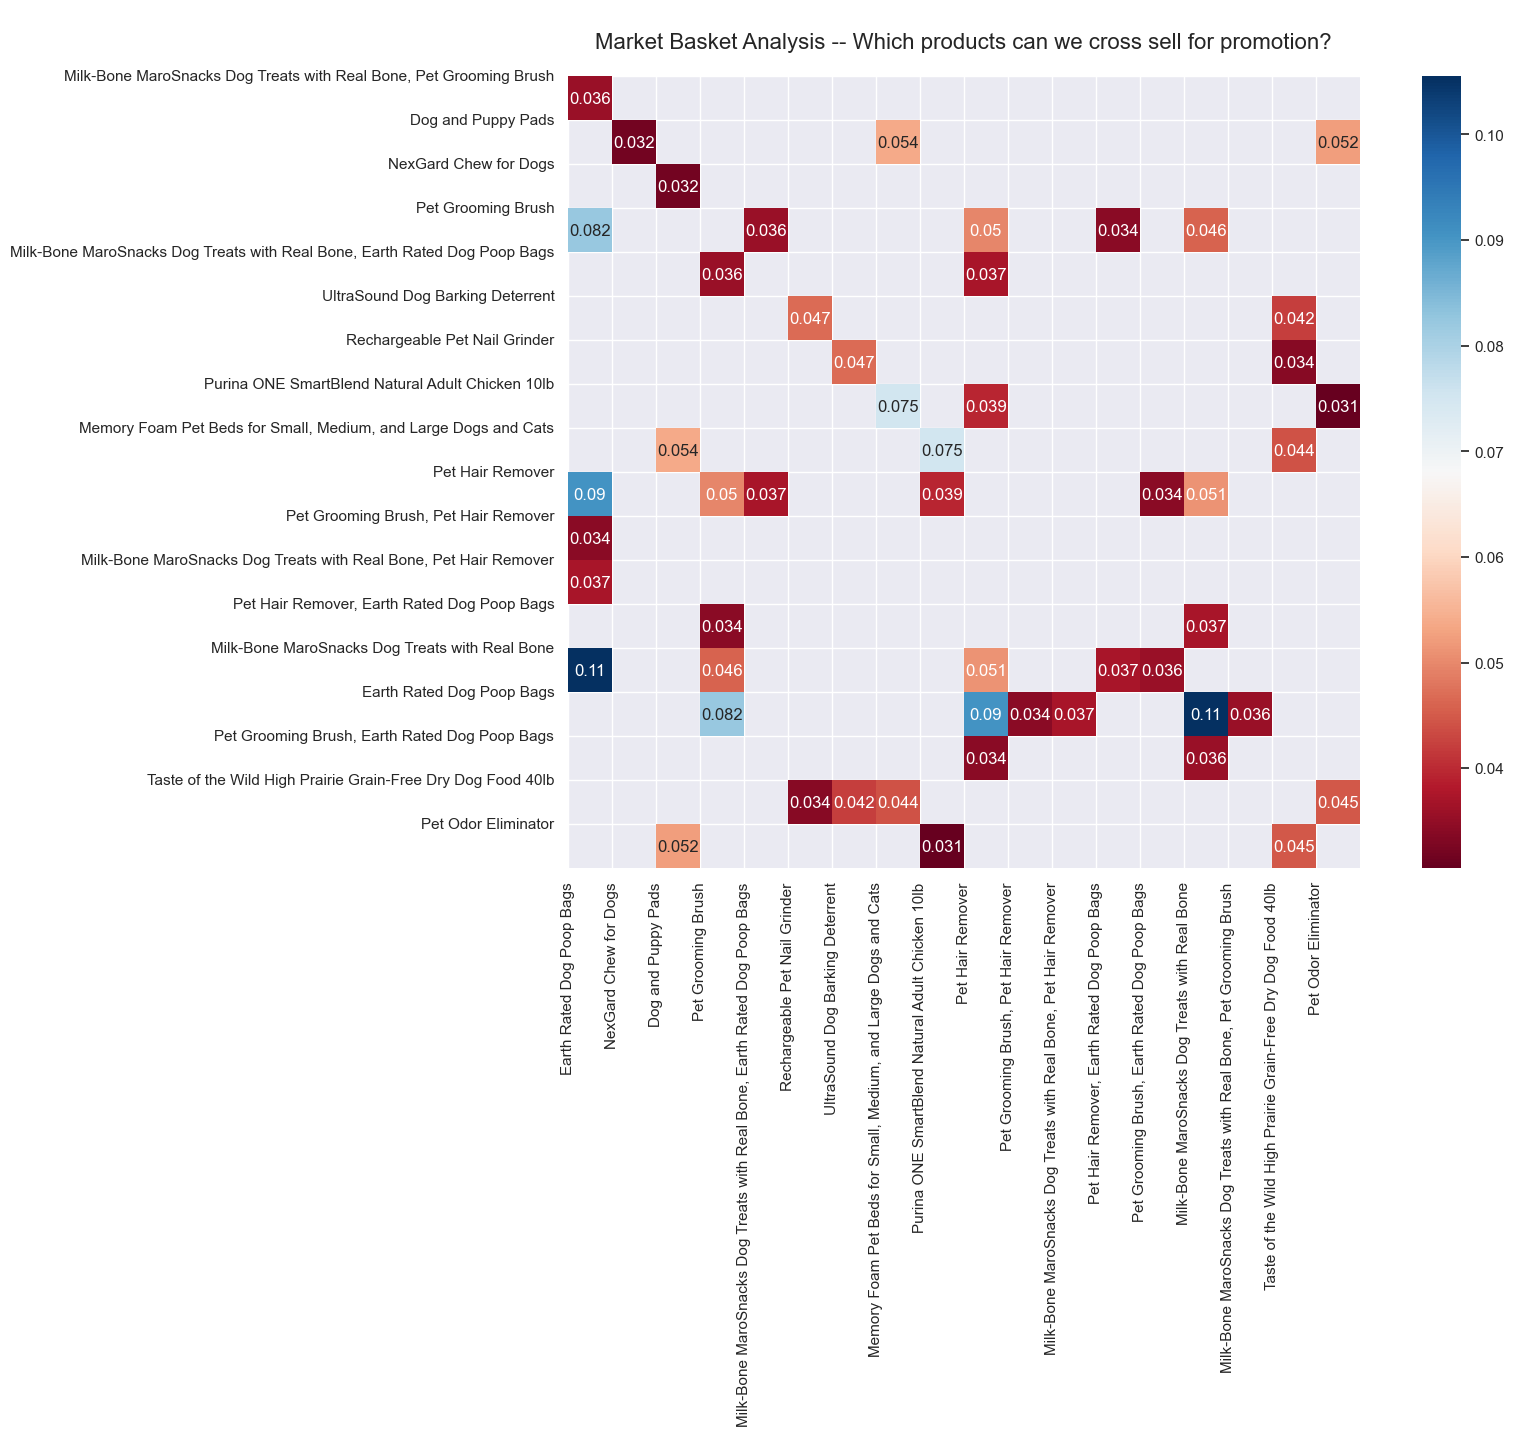

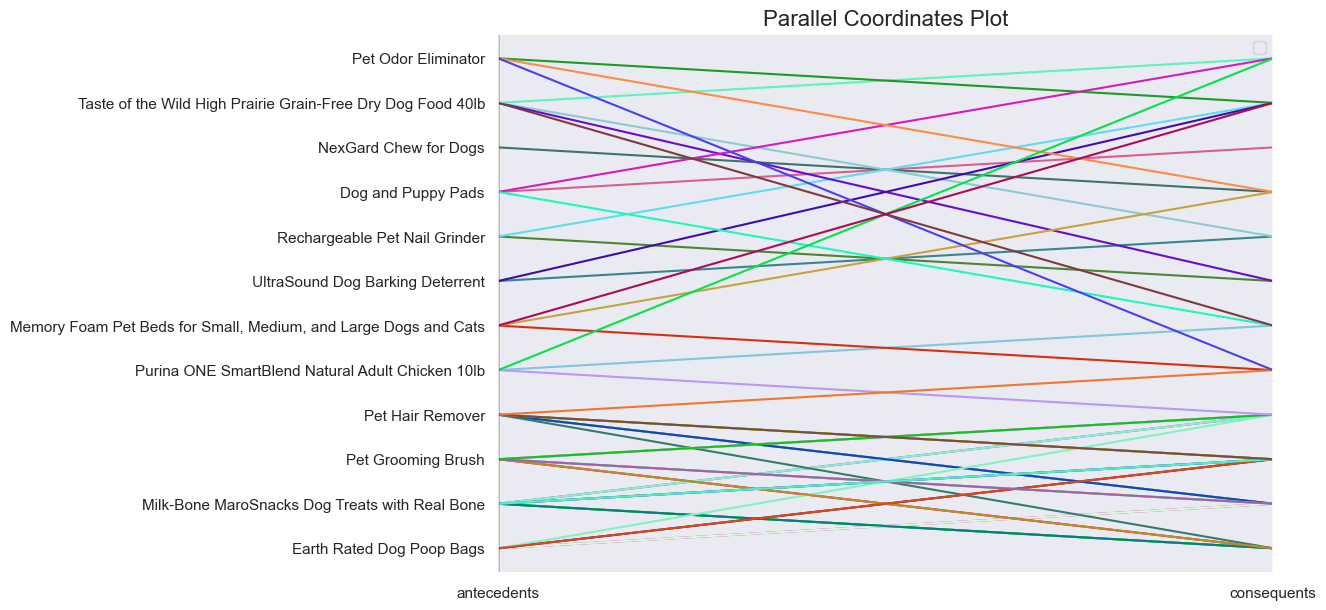

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from pandas.plotting import parallel_coordinates

# Import dataset
df = pd.read_csv('fact_sales.csv')

# Inspect dataset
#print(df.head) [25065 rows x 8 columns]>

# Dropping nulls  
df = df.dropna()

# How much data was dropped? Approximately 20%
#print(df.head) [19996 rows x 8 columns]>

# Remove negative quantities which represent returns
df_ohne_neg = df[df['Quantity']>0]


# Summarize the original data with quantities grouped by invoice number and description
# Reshape resulting grouped data by converting 'Description' into column headers. The corresponding quantities are filled in the respective cells.
basket_plus = df_ohne_neg.groupby(['Invoice No', 'Description'])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('Invoice No')


# Encode the basket data into binary data that shows whether an items is bought (1) or not (0)
def encode_units (x):
    if x <= 0:
        return 0
    else:
        return 1
basket_encode_plus = (basket_plus.applymap(encode_units)).astype(bool)


# Filter out transactions with only 1 item since we're trying to make an association affinity analysis
basket_filter_plus = basket_encode_plus[basket_encode_plus.sum(axis=1) >=2]


# Apply the Apriori Algorithm
frequent_itemset_plus = apriori(basket_filter_plus, min_support=0.03,use_colnames=True).sort_values('support', ascending=False).reset_index(drop=True)


# Apply the association rules
frequent_itemset_plus_ass = association_rules(frequent_itemset_plus, metric='lift', min_threshold=1).sort_values('lift', ascending=False).reset_index(drop=True)


# Create heatmap
support_table = frequent_itemset_plus_ass.pivot(index='consequents', columns='antecedents', values='support')

# Set the figure size to make the heatmap wider
plt.figure(figsize=(16, 8))

# Convert the column names (antecedents) to strings to subscript product names from frozen set
support_table.columns = [', '.join(col) for col in support_table.columns]

# Convert the index (consequents) to strings to subscript product names from frozen set
support_table.index = [', '.join(index) for index in support_table.index]

# Plot the chart
sns.set()
heatmap_plot = sns.heatmap(data=support_table, annot=True, cmap='RdBu', square=True)
plt.xticks(range(len(support_table.columns)), support_table.columns, rotation=90)
plt.yticks(range(len(support_table.index)), support_table.index)
heatmap_plot.set_title('\nMarket Basket Analysis -- Which products can we cross sell for promotion?', pad=20, fontsize=16)

# Creat space between title and chart
plt.subplots_adjust(top=1.1)

# Display chart
plt.show()


# PARALLEL COORDINATES PLOT
plt.figure(figsize=(10, 7))
frequent_itemset_plus_ass['antecedents'] = frequent_itemset_plus_ass['antecedents'].apply(lambda antecedent: list(antecedent)[0])
frequent_itemset_plus_ass['consequents'] = frequent_itemset_plus_ass['consequents'].apply(lambda consequent: list(consequent)[0])
frequent_itemset_plus_ass['rule'] = frequent_itemset_plus_ass.index
coords = frequent_itemset_plus_ass[['antecedents', 'consequents', 'rule']]
parallel_coordinates(coords, 'rule')
plt.legend([])
plt.title("Parallel Coordinates Plot", fontsize=16)
plt.show()

